## Import libraries

In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

## Load data

In [11]:
df = pd.read_csv("./Data/IMDB Dataset SPANISH.csv")
df.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50000 non-null  int64 
 1   review_en    50000 non-null  object
 2   review_es    50000 non-null  object
 3   sentiment    50000 non-null  object
 4   sentimiento  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [13]:
df['en'] = 'en'
df['es'] = 'es'
df_en = df[['review_en','en']]
df_es = df[['review_es','es']]
df_en.columns = ['review','languaje']
df_es.columns = ['review','languaje']
df = pd.concat([df_en, df_es], ignore_index=True)
df = df.sample(frac=1, random_state=42)
df.head()

,review,languaje
75721,Los Estados Unidos todavía estaban luchando co...,es
80184,Gregory Peck da un rendimiento brillante en es...,es
19864,I watched this last night after not having see...,en
76699,Atrapado esto recientemente después de notar e...,es
92991,Esta pieza de conjunto sobre adultos que regre...,es


## Process data

In [14]:
def cleaning_sentence(sentence):
    sentence = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ\s\'-]', ' ', sentence)
    sentence = sentence.lower().strip()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [15]:
def cleaning_sentence_es(sentence):
    sentence = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ ]', '', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [16]:
def cleaning_sentence_en(sentence):
    sentence = re.sub(r'[^a-zA-Z\s\'-]', '', sentence)
    sentence = sentence.lower().strip()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [17]:
def tokenize_sentences(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentences.append(sentence.split())
    return tokenized_sentences

In [18]:
df['review'] = df['review'].apply(cleaning_sentence)
tokenized_sentences = tokenized_sentences(df['review'])

In [19]:
df.head()

,review,languaje
75721,los estados unidos todavía estaban luchando co...,es
80184,gregory peck da un rendimiento brillante en es...,es
19864,i watched this last night after not having see...,en
76699,atrapado esto recientemente después de notar e...,es
92991,esta pieza de conjunto sobre adultos que regre...,es


## Word Cloud

In [22]:
corpus = ' '.join(df['review'].to_list())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

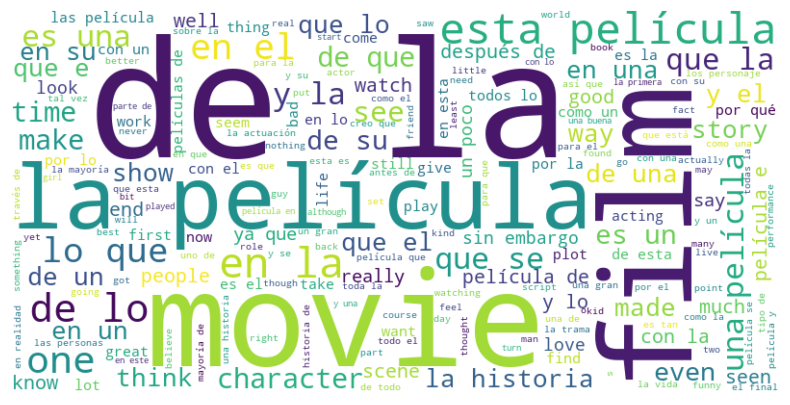

In [23]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()